In [1]:
import os
import sys
import json
import boto3
import logging
import psycopg2
import datetime
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import udf, struct, countDistinct
import multiprocessing
pd.set_option('display.max_columns', None)
N_CORES = min(
    multiprocessing.cpu_count(), 
    int(float(os.environ['CPU_LIMIT']))
)
print('max cores available:', N_CORES)

max cores available: 5


In [2]:
print('user:', os.environ['JUPYTERHUB_SERVICE_PREFIX'])

def uiWebUrl(self):
    from urllib.parse import urlparse
    web_url = self._jsc.sc().uiWebUrl().get()
    port = urlparse(web_url).port
    return '{}proxy/{}/jobs/'.format(os.environ['JUPYTERHUB_SERVICE_PREFIX'], port)

SparkContext.uiWebUrl = property(uiWebUrl)

conf = SparkConf()
conf.set('spark.master', 'local[*]')
conf.set('spark.driver.memory', '12G')
conf.set('spark.driver.maxResultSize', '4G')
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark

user: /user/st112143/


In [3]:
k8s = pd.read_csv('kubernetes_events.csv',  sep=';')

In [4]:
k8s

,time_stamp,stream,kubernetes_host,kubernetes_pod_name,verb,event_uid,event_creation_timestamp,event_name,event_namespace,involved_object_kind,involved_object_namespace,involved_object_name,event_reason,event_message
0,2023-09-27 09:26:36.532341,stderr,cl1llpobhs2ijlf53v62-imaj,eventrouter-5874bd6747-dwfj4,UPDATED,c9a5ed86-614e-4259-9a31-0abd21af3baf,2023-09-20 21:16:28,claim-st082199.1786b7f8b8079bcc,jhub,PersistentVolumeClaim,jhub,claim-st082199,WaitForFirstConsumer,waiting for first consumer to be created befor...
1,2023-09-27 09:26:36.546469,stderr,cl1llpobhs2ijlf53v62-imaj,eventrouter-5874bd6747-dwfj4,UPDATED,1dea347c-347e-41e5-a6d3-4892753761a0,2023-09-20 21:16:28,claim-st097893.1786b7f8baa03370,jhub,PersistentVolumeClaim,jhub,claim-st097893,WaitForFirstConsumer,waiting for first consumer to be created befor...
2,2023-09-27 09:30:50.184708,stderr,cl1llpobhs2ijlf53v62-imaj,eventrouter-5874bd6747-dwfj4,UPDATED,cce2716b-37d0-4753-a1a3-fe4cc1d251c4,2023-09-27 08:30:33,continuous-image-puller-4vqk2.1788b43cea1c5007,jhub,Pod,jhub,continuous-image-puller-4vqk2,Pulled,"Container image ""cr.yandex/crptfs8246iv37ojkor..."
3,2023-09-27 09:30:50.184766,stderr,cl1llpobhs2ijlf53v62-imaj,eventrouter-5874bd6747-dwfj4,UPDATED,a83988f4-bbc9-4269-bb8d-98e09570d474,2023-09-27 08:30:35,continuous-image-puller-4vqk2.1788b43d740ba60c,jhub,Pod,jhub,continuous-image-puller-4vqk2,Started,Started container image-pull-singleuser-profil...
4,2023-09-27 09:30:50.184828,stderr,cl1llpobhs2ijlf53v62-imaj,eventrouter-5874bd6747-dwfj4,UPDATED,ec5b8523-c890-460a-907c-f7ee41a3f625,2023-09-27 08:30:40,continuous-image-puller-zczf4.1788b43e92174a29,jhub,Pod,jhub,continuous-image-puller-zczf4,Pulled,"Container image ""jupyterhub/k8s-network-tools:..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007357,2023-11-18 21:36:54.360190,stderr,cl1llpobhs2ijlf53v62-aluf,eventrouter-5874bd6747-fqvfz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1007358,2023-11-18 21:40:51.964239,stderr,cl1llpobhs2ijlf53v62-aluf,eventrouter-5874bd6747-fqvfz,UPDATED,06aec7f7-e6e9-4eb6-aeec-a86b2d71859f,2023-11-10 10:00:44,claim-st082199.17963ab1ababb2c3,jhub,PersistentVolumeClaim,jhub,claim-st082199,WaitForFirstConsumer,waiting for first consumer to be created befor...
1007359,2023-11-18 21:40:51.983044,stderr,cl1llpobhs2ijlf53v62-aluf,eventrouter-5874bd6747-fqvfz,UPDATED,1980f051-bb34-4d9c-8004-871a98feb253,2023-11-10 10:00:44,claim-st097893.17963ab1af9b625f,jhub,PersistentVolumeClaim,jhub,claim-st097893,WaitForFirstConsumer,waiting for first consumer to be created befor...
1007360,2023-03-09 15:14:41.173970,stderr,cl1flrrk4hvdbm084md4-elef,eventrouter-5874bd6747-nfbjv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
logs = pd.read_csv('jhub_logs.csv',  sep=';')

In [6]:
logs

,time_stamp,kuber_container_name,kuber_host,kuber_pod_name,log_head,log_timestamp,log_service,log_type,log_code,log_msg
0,2023-04-06 13:40:43.589082,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,I,2023-04-06 13:40:43.588,JupyterHub,log,181.0,302 GET /user/st095441/api/contents/__VK/model...
1,2023-04-06 13:40:43.619658,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,I,2023-04-06 13:40:43.619,JupyterHub,log,181.0,302 GET /hub/user/st095441/api/contents/__VK/m...
2,2023-04-06 13:40:43.653159,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,I,2023-04-06 13:40:43.652,JupyterHub,log,181.0,200 GET /hub/login?next=%2Fhub%2Fuser%2Fst0954...
3,2023-04-06 13:40:43.793204,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,W,2023-04-06 13:40:43.792,JupyterHub,log,181.0,405 PUT /user/st095441/api/contents/__VK/model...
4,2023-04-06 13:40:56.665458,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,I,2023-04-06 13:40:56.664,JupyterHub,proxy,319.0,Checking routes
...,...,...,...,...,...,...,...,...,...,...
4575910,2023-10-20 09:53:50.954623,git-clone-templates,cl1llpobhs2ijlf53v62-aluf,hub-f747d85cf-l7mw5,NaN,NaN,NaN,NaN,NaN,Cloning into '/etc/jupyterhub/custom'...\n
4575911,2023-10-20 10:22:49.850447,git-clone-templates,cl1llpobhs2ijlf53v62-aluf,hub-f747d85cf-nnkkp,NaN,NaN,NaN,NaN,NaN,Cloning into '/etc/jupyterhub/custom'...\n
4575912,2023-10-23 05:01:12.068719,git-clone-templates,cl1llpobhs2ijlf53v62-aluf,hub-f747d85cf-p9qf6,NaN,NaN,NaN,NaN,NaN,Cloning into '/etc/jupyterhub/custom'...\n
4575913,2023-10-23 18:23:21.728021,git-clone-templates,cl1llpobhs2ijlf53v62-obin,hub-f747d85cf-pn8r7,NaN,NaN,NaN,NaN,NaN,Cloning into '/etc/jupyterhub/custom'...\n


In [7]:
logs = logs.dropna()
logs

,time_stamp,kuber_container_name,kuber_host,kuber_pod_name,log_head,log_timestamp,log_service,log_type,log_code,log_msg
0,2023-04-06 13:40:43.589082,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,I,2023-04-06 13:40:43.588,JupyterHub,log,181.0,302 GET /user/st095441/api/contents/__VK/model...
1,2023-04-06 13:40:43.619658,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,I,2023-04-06 13:40:43.619,JupyterHub,log,181.0,302 GET /hub/user/st095441/api/contents/__VK/m...
2,2023-04-06 13:40:43.653159,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,I,2023-04-06 13:40:43.652,JupyterHub,log,181.0,200 GET /hub/login?next=%2Fhub%2Fuser%2Fst0954...
3,2023-04-06 13:40:43.793204,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,W,2023-04-06 13:40:43.792,JupyterHub,log,181.0,405 PUT /user/st095441/api/contents/__VK/model...
4,2023-04-06 13:40:56.665458,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,I,2023-04-06 13:40:56.664,JupyterHub,proxy,319.0,Checking routes
...,...,...,...,...,...,...,...,...,...,...
4575851,2023-08-03 02:15:54.233354,hub,cl1llpobhs2ijlf53v62-yjof,hub-77d4b9fbd-9hrmk,I,2023-08-03 02:15:54.233,JupyterHub,log,186.0,200 POST /hub/api/users/st067810/activity (st0...
4575852,2023-08-03 06:18:17.779582,hub,cl1llpobhs2ijlf53v62-yjof,hub-77d4b9fbd-9hrmk,I,2023-08-03 06:18:17.779,JupyterHub,log,186.0,200 POST /hub/api/users/st067810/activity (st0...
4575853,2023-08-03 07:58:30.291657,hub,cl1llpobhs2ijlf53v62-yjof,hub-77d4b9fbd-9hrmk,I,2023-08-03 07:58:30.291,JupyterHub,log,186.0,200 POST /hub/api/users/st067810/activity (st0...
4575878,2023-06-28 09:16:57.429715,hub,cl1llpobhs2ijlf53v62-anes,hub-557fbb85c-8nkl4,I,2023-06-28 09:16:57.429,JupyterHub,log,181.0,200 POST /hub/api/users/vgarshin/activity (vga...


In [8]:
k8s = k8s.dropna()
k8s

,time_stamp,stream,kubernetes_host,kubernetes_pod_name,verb,event_uid,event_creation_timestamp,event_name,event_namespace,involved_object_kind,involved_object_namespace,involved_object_name,event_reason,event_message
0,2023-09-27 09:26:36.532341,stderr,cl1llpobhs2ijlf53v62-imaj,eventrouter-5874bd6747-dwfj4,UPDATED,c9a5ed86-614e-4259-9a31-0abd21af3baf,2023-09-20 21:16:28,claim-st082199.1786b7f8b8079bcc,jhub,PersistentVolumeClaim,jhub,claim-st082199,WaitForFirstConsumer,waiting for first consumer to be created befor...
1,2023-09-27 09:26:36.546469,stderr,cl1llpobhs2ijlf53v62-imaj,eventrouter-5874bd6747-dwfj4,UPDATED,1dea347c-347e-41e5-a6d3-4892753761a0,2023-09-20 21:16:28,claim-st097893.1786b7f8baa03370,jhub,PersistentVolumeClaim,jhub,claim-st097893,WaitForFirstConsumer,waiting for first consumer to be created befor...
2,2023-09-27 09:30:50.184708,stderr,cl1llpobhs2ijlf53v62-imaj,eventrouter-5874bd6747-dwfj4,UPDATED,cce2716b-37d0-4753-a1a3-fe4cc1d251c4,2023-09-27 08:30:33,continuous-image-puller-4vqk2.1788b43cea1c5007,jhub,Pod,jhub,continuous-image-puller-4vqk2,Pulled,"Container image ""cr.yandex/crptfs8246iv37ojkor..."
3,2023-09-27 09:30:50.184766,stderr,cl1llpobhs2ijlf53v62-imaj,eventrouter-5874bd6747-dwfj4,UPDATED,a83988f4-bbc9-4269-bb8d-98e09570d474,2023-09-27 08:30:35,continuous-image-puller-4vqk2.1788b43d740ba60c,jhub,Pod,jhub,continuous-image-puller-4vqk2,Started,Started container image-pull-singleuser-profil...
4,2023-09-27 09:30:50.184828,stderr,cl1llpobhs2ijlf53v62-imaj,eventrouter-5874bd6747-dwfj4,UPDATED,ec5b8523-c890-460a-907c-f7ee41a3f625,2023-09-27 08:30:40,continuous-image-puller-zczf4.1788b43e92174a29,jhub,Pod,jhub,continuous-image-puller-zczf4,Pulled,"Container image ""jupyterhub/k8s-network-tools:..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007353,2023-11-18 19:40:50.603862,stderr,cl1llpobhs2ijlf53v62-aluf,eventrouter-5874bd6747-fqvfz,UPDATED,06aec7f7-e6e9-4eb6-aeec-a86b2d71859f,2023-11-10 10:00:44,claim-st082199.17963ab1ababb2c3,jhub,PersistentVolumeClaim,jhub,claim-st082199,WaitForFirstConsumer,waiting for first consumer to be created befor...
1007355,2023-11-18 20:30:51.145523,stderr,cl1llpobhs2ijlf53v62-aluf,eventrouter-5874bd6747-fqvfz,UPDATED,1980f051-bb34-4d9c-8004-871a98feb253,2023-11-10 10:00:44,claim-st097893.17963ab1af9b625f,jhub,PersistentVolumeClaim,jhub,claim-st097893,WaitForFirstConsumer,waiting for first consumer to be created befor...
1007356,2023-11-18 20:30:51.153686,stderr,cl1llpobhs2ijlf53v62-aluf,eventrouter-5874bd6747-fqvfz,UPDATED,06aec7f7-e6e9-4eb6-aeec-a86b2d71859f,2023-11-10 10:00:44,claim-st082199.17963ab1ababb2c3,jhub,PersistentVolumeClaim,jhub,claim-st082199,WaitForFirstConsumer,waiting for first consumer to be created befor...
1007358,2023-11-18 21:40:51.964239,stderr,cl1llpobhs2ijlf53v62-aluf,eventrouter-5874bd6747-fqvfz,UPDATED,06aec7f7-e6e9-4eb6-aeec-a86b2d71859f,2023-11-10 10:00:44,claim-st082199.17963ab1ababb2c3,jhub,PersistentVolumeClaim,jhub,claim-st082199,WaitForFirstConsumer,waiting for first consumer to be created befor...


In [9]:
k8s['event_creation_timestamp'] = pd.to_datetime(k8s['event_creation_timestamp'])

/tmp/ipykernel_590/3639921363.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k8s['event_creation_timestamp'] = pd.to_datetime(k8s['event_creation_timestamp'])


In [10]:
event_counts = k8s['event_reason'].value_counts()
print(event_counts)

Pulled                      183603
Created                     170859
Started                     169388
Scheduled                    79988
SuccessfulAttachVolume       54066
WaitForFirstConsumer         51287
Killing                      50751
SuccessfulCreate             36833
SuccessfulDelete             23371
FailedDaemonPod              21854
Pulling                      21188
LeaderElection               17281
Shutdown                     16659
FailedMount                  13808
FailedScheduling             10681
Preempted                     8842
Failed                        5135
UpdatedLoadBalancer           3653
Unhealthy                     3197
ScalingReplicaSet             2891
FailedCreate                  2742
ScaleDown                     2466
FailedCreatePodSandBox        1831
TriggeredScaleUp              1754
ExternalProvisioning          1724
NoPods                        1551
Provisioning                  1416
ScaledUpGroup                 1411
ScaleDownEmpty      

In [11]:
failed_k8s_events = k8s[k8s['event_reason'].str.contains("Failed")]
failed_counts = failed_k8s_events['event_reason'].value_counts()
print(failed_counts)

FailedDaemonPod             21854
FailedMount                 13808
FailedScheduling            10681
Failed                       5135
FailedCreate                 2742
FailedCreatePodSandBox       1831
FailedAttachVolume           1315
FailedSync                    660
FailedPreStopHook             456
ProvisioningFailed            387
FailedPostStartHook           174
UpdateLoadBalancerFailed      161
FailedKillPod                  48
FailedToUpdateEndpoint         48
SyncLoadBalancerFailed         34
Name: event_reason, dtype: int64


In [12]:
failed_k8s_events = k8s[k8s['event_reason'].str.contains("Failed") | 
                         k8s['event_reason'].isin(["Unhealthy", "NoPods", "NodeNotReady", 
                                                   "NetworkNotReady", "UnAvailableLoadBalancer", 
                                                   "OutOfpods"])]
failed_counts = failed_k8s_events['event_reason'].value_counts()
print(failed_counts)


FailedDaemonPod             21854
FailedMount                 13808
FailedScheduling            10681
Failed                       5135
Unhealthy                    3197
FailedCreate                 2742
FailedCreatePodSandBox       1831
NoPods                       1551
FailedAttachVolume           1315
FailedSync                    660
FailedPreStopHook             456
NodeNotReady                  391
ProvisioningFailed            387
FailedPostStartHook           174
UpdateLoadBalancerFailed      161
FailedKillPod                  48
FailedToUpdateEndpoint         48
SyncLoadBalancerFailed         34
NetworkNotReady                25
OutOfpods                      15
UnAvailableLoadBalancer         6
Name: event_reason, dtype: int64


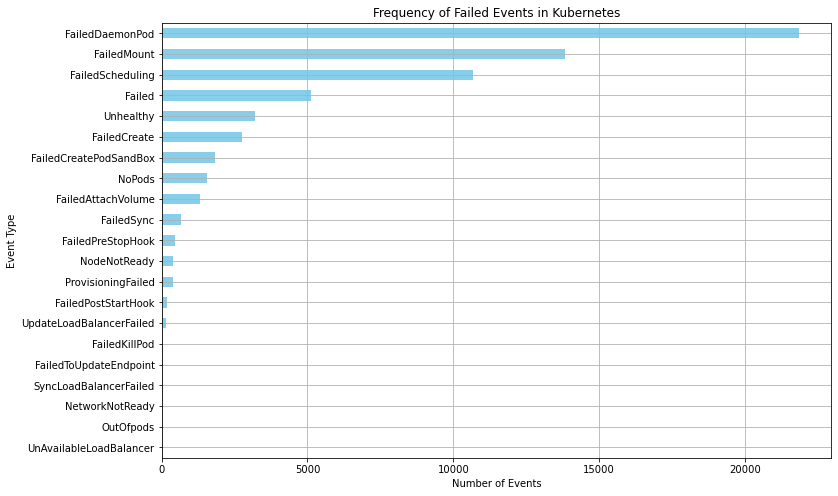

In [13]:
plt.figure(figsize=(12, 8))
failed_counts.sort_values().plot(kind='barh', color='skyblue')
plt.title('Frequency of Failed Events in Kubernetes')
plt.xlabel('Number of Events')
plt.ylabel('Event Type')
plt.grid(True)


plt.show()

### Correlation with User Activity

In [14]:
failed_k8s_events_by_time = failed_k8s_events.resample('H', on='event_creation_timestamp').size()

In [15]:
logs['log_timestamp'] = pd.to_datetime(logs['log_timestamp'])

/tmp/ipykernel_590/2286328773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs['log_timestamp'] = pd.to_datetime(logs['log_timestamp'])


In [16]:
# Aggregate user activity by the same time period used for Kubernetes events 
user_activity_by_time = logs.resample('H', on='log_timestamp').size()

In [17]:
# Merge the two aggregated series into a single DataFrame to compute correlation
time_analysis_df = pd.DataFrame({
    'failed_events_count': failed_k8s_events_by_time,
    'user_activity_count': user_activity_by_time
})

In [18]:
# Drop any NaN values that may have resulted from the resampling
time_analysis_df = time_analysis_df.dropna()

In [19]:
# Calculate the correlation
correlation = time_analysis_df.corr()

print(correlation)

                     failed_events_count  user_activity_count
failed_events_count             1.000000             0.078766
user_activity_count             0.078766             1.000000


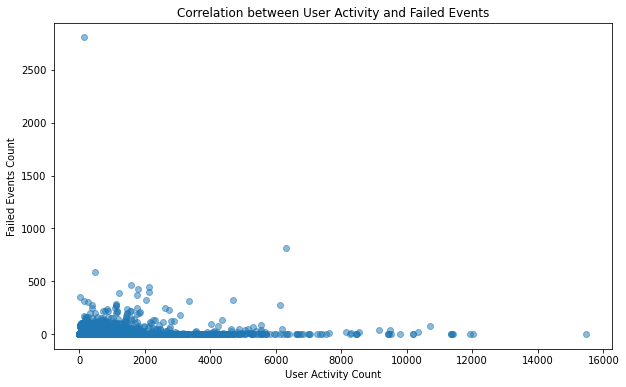

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(time_analysis_df['user_activity_count'], time_analysis_df['failed_events_count'], alpha=0.5)
plt.title('Correlation between User Activity and Failed Events')
plt.xlabel('User Activity Count')
plt.ylabel('Failed Events Count')
plt.show()


### Temporal Analysis

In [21]:
# Group data by day and count events
failed_by_day = failed_k8s_events.resample('D', on='event_creation_timestamp').size()

# This creates a time-series of event counts per day
print(failed_by_day)

event_creation_timestamp
2023-01-15      4
2023-01-16     28
2023-01-17      4
2023-01-18      8
2023-01-19     18
             ... 
2023-11-27    172
2023-11-28    448
2023-11-29    289
2023-11-30    113
2023-12-01      9
Freq: D, Length: 321, dtype: int64


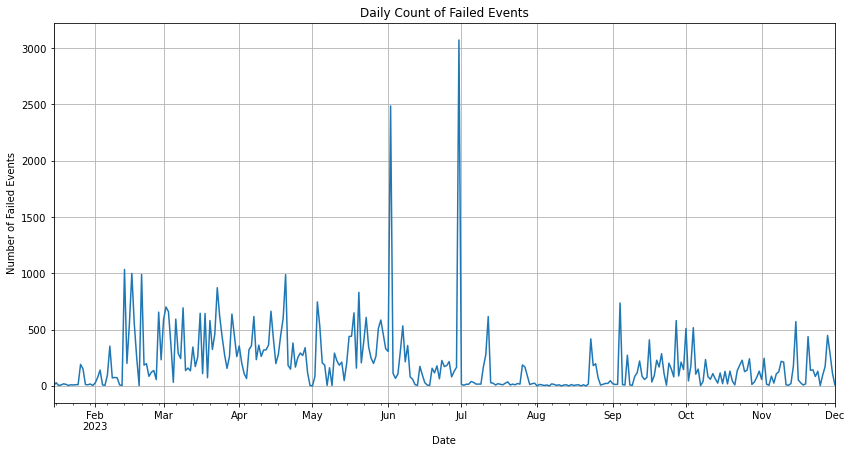

In [22]:
plt.figure(figsize=(14, 7)) 
failed_by_day.plot()
plt.title('Daily Count of Failed Events')
plt.xlabel('Date')
plt.ylabel('Number of Failed Events')
plt.grid(True)
plt.show()

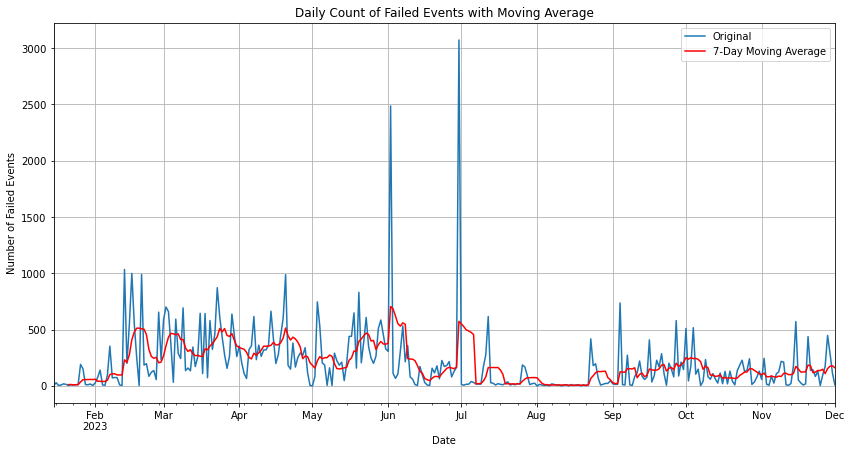

In [23]:
# Calculate the moving average
moving_avg = failed_by_day.rolling(window=7).mean()  # 7-day moving average

# Plot the original data and the moving average
plt.figure(figsize=(14, 7))
failed_by_day.plot(label='Original')
moving_avg.plot(label='7-Day Moving Average', color='red')
plt.title('Daily Count of Failed Events with Moving Average')
plt.xlabel('Date')
plt.ylabel('Number of Failed Events')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
outliers = failed_by_day[failed_by_day > (failed_by_day.mean() + 3 * failed_by_day.std())]
print(outliers)

event_creation_timestamp
2023-06-02    2486
2023-06-30    3072
dtype: int64


In [25]:
# Add a 'day_of_week' column
failed_k8s_events['day_of_week'] = failed_k8s_events['event_creation_timestamp'].dt.day_name()

# Group by 'day_of_week' and count events
failed_by_day_of_week = failed_k8s_events.groupby('day_of_week').size()
print(failed_by_day_of_week)

day_of_week
Friday       13218
Monday        9728
Saturday      5974
Sunday        4316
Thursday     11694
Tuesday       7762
Wednesday    11827
dtype: int64


/tmp/ipykernel_590/2923874368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_k8s_events['day_of_week'] = failed_k8s_events['event_creation_timestamp'].dt.day_name()


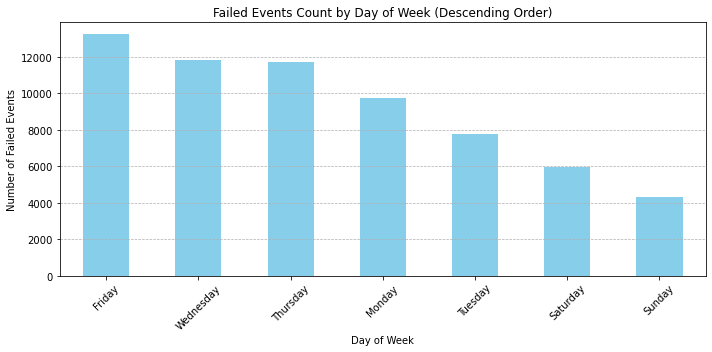

In [26]:
plt.figure(figsize=(10, 5))
failed_by_day_of_week_sorted = failed_by_day_of_week.sort_values(ascending=False)
failed_by_day_of_week_sorted.plot(kind='bar', color='skyblue')
plt.title('Failed Events Count by Day of Week (Descending Order)')
plt.xlabel('Day of Week')
plt.ylabel('Number of Failed Events')
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()  
plt.show()

/tmp/ipykernel_590/710446365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_k8s_events['hour'] = failed_k8s_events['event_creation_timestamp'].dt.hour


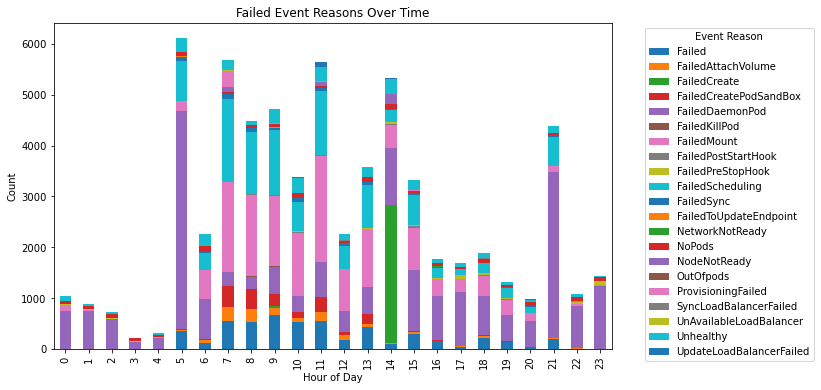

In [28]:
failed_k8s_events['hour'] = failed_k8s_events['event_creation_timestamp'].dt.hour
failed_hourly_event_counts = failed_k8s_events.groupby([failed_k8s_events['hour'], 'event_reason']).size().unstack(fill_value=0)

failed_hourly_event_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Failed Event Reasons Over Time')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.xticks(range(24), range(24))
plt.legend(title='Event Reason', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

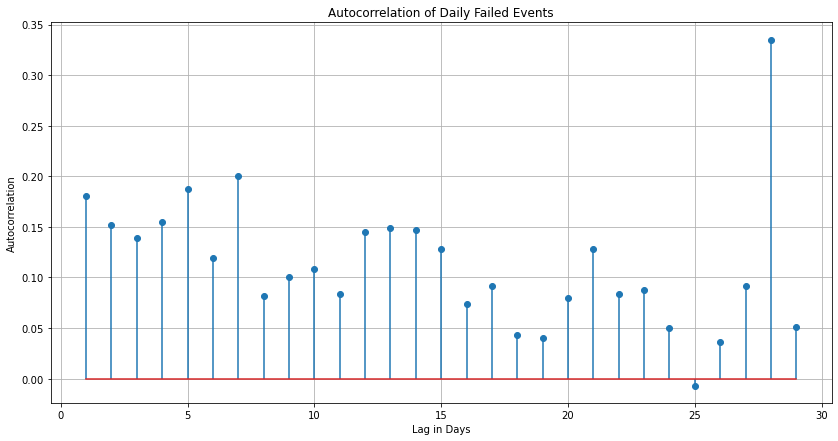

In [57]:
# Calculate autocorrelation for different lags
autocorrelation = [failed_by_day.autocorr(lag=i) for i in range(1, 30)]

# Plot the autocorrelation to see if there are any significant correlations
plt.figure(figsize=(14, 7))
plt.stem(range(1, 30), autocorrelation)
plt.title('Autocorrelation of Daily Failed Events')
plt.xlabel('Lag in Days')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

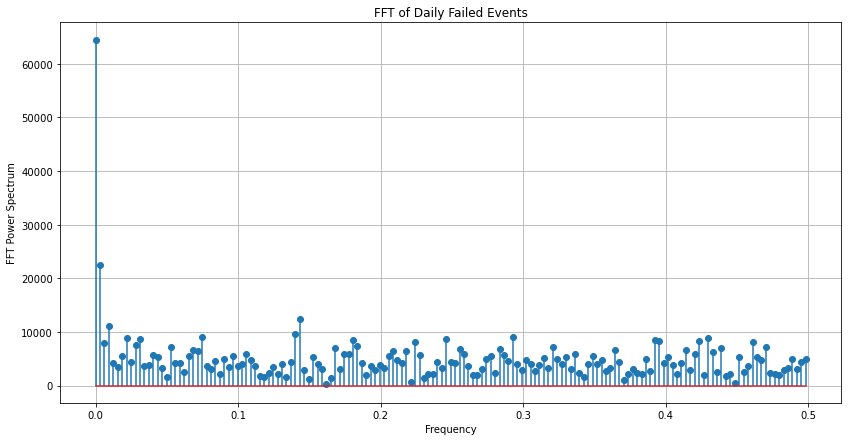

In [58]:
from scipy.fft import rfft, rfftfreq

# Perform a real fast Fourier transform
y_fft = rfft(failed_by_day)
x_fft = rfftfreq(n=failed_by_day.size, d=1)

# Plot the FFT power spectrum
plt.figure(figsize=(14, 7))
plt.stem(x_fft, np.abs(y_fft))
plt.title('FFT of Daily Failed Events')
plt.xlabel('Frequency')
plt.ylabel('FFT Power Spectrum')
plt.grid(True)
plt.show()

### Pod Analysis

In [59]:
# Group by 'kubernetes_pod_name' and count the number of failed events
failed_by_pod = failed_k8s_events.groupby('kubernetes_pod_name').size().sort_values(ascending=False)

In [60]:
print(failed_by_pod.head()) 

kubernetes_pod_name
eventrouter-5874bd6747-nfbjv    30376
eventrouter-5874bd6747-9k2m2    14362
eventrouter-5874bd6747-fqvfz     7199
eventrouter-5874bd6747-dwfj4     6232
eventrouter-5874bd6747-tpmx8     4251
dtype: int64


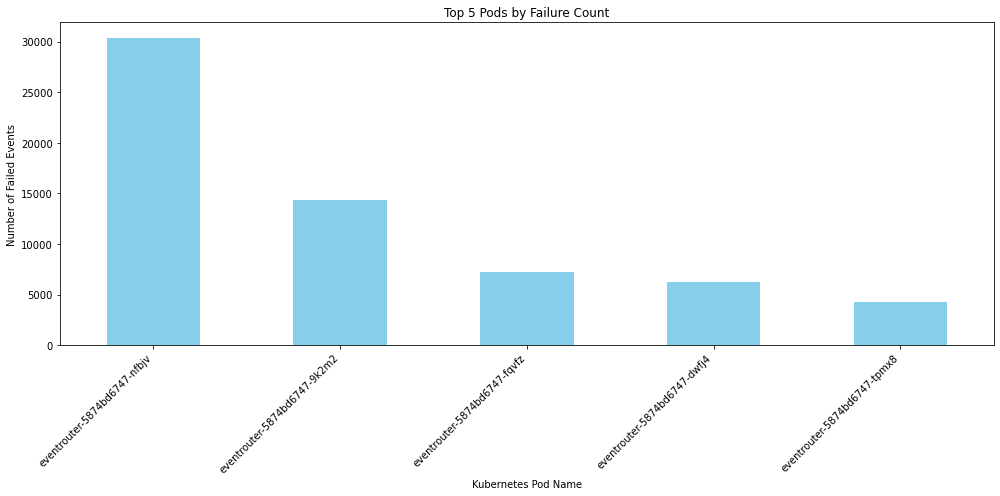

In [61]:
top_n = 5 
failed_by_pod.head(top_n).plot(kind='bar', figsize=(14, 7), color='skyblue')
plt.title(f'Top {top_n} Pods by Failure Count')
plt.xlabel('Kubernetes Pod Name')
plt.ylabel('Number of Failed Events')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout() 
plt.show()

### Host Analysis

In [62]:
failed_by_host = failed_k8s_events.groupby('kubernetes_host').size().sort_values(ascending=False)

In [63]:
print(failed_by_host.head())  

kubernetes_host
cl1flrrk4hvdbm084md4-elef    30376
cl1llpobhs2ijlf53v62-anes    14362
cl1llpobhs2ijlf53v62-aluf     7199
cl1llpobhs2ijlf53v62-imaj     6232
cl1llpobhs2ijlf53v62-ydax     4251
dtype: int64


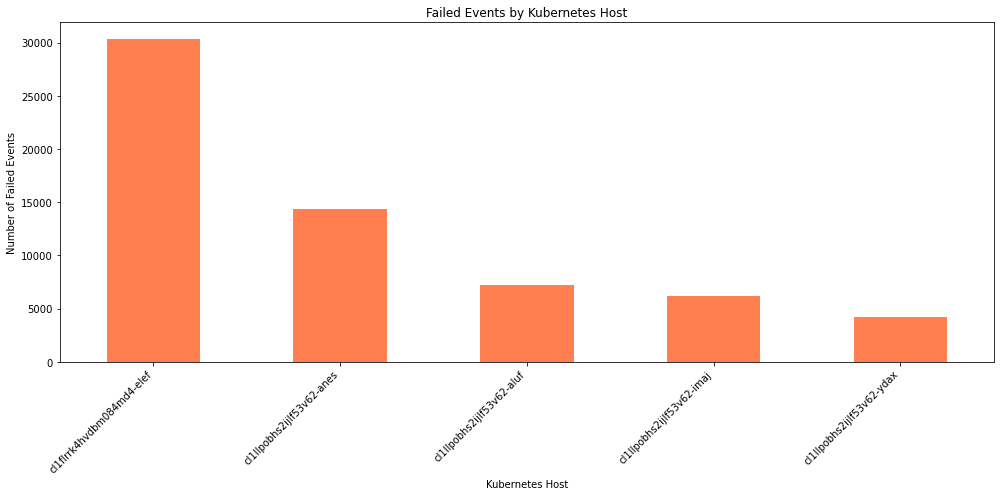

In [65]:
top_n_hosts = 5  
failed_by_host.head(top_n_hosts).plot(kind='bar', figsize=(14, 7), color='coral')
plt.title('Failed Events by Kubernetes Host')
plt.xlabel('Kubernetes Host')
plt.ylabel('Number of Failed Events')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()